# Exploração de carcterísticas

In [3]:
import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname('__file__'), '.env')

load_dotenv(dotenv_path)

RAW_DATA = os.environ.get("RAW_DATA")
PROCESSED_DATA = os.environ.get("PROCESSED_DATA")
ROOT_PATH = os.environ.get("ROOT_PATH")


In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [210]:
file = 'PN00-1.parquet'

path = f"{ROOT_PATH}{PROCESSED_DATA}ecg_features/"

In [211]:
sem_crise = pd.read_parquet(f"{path}sem_crise/{file}")
com_crise = pd.read_parquet(f"{path}com_crise/{file}")

# Inserindo rótulos
# Sem crise -> 1
# Com crise -> 0
sem_crise['label'] = np.repeat('sem_crise', len(sem_crise))
com_crise['label'] = np.repeat('com_crise', len(com_crise))

df = pd.concat([sem_crise,com_crise])


In [212]:
# Tratamento de valores nulos
for col in df.columns[:-1]:
    df[col] = df[col].fillna(df[col].mean())

## Seleção de Características

- Selecionando as 2 features como maior relevância

In [217]:
from sklearn.feature_selection import SelectKBest, f_classif

x = df.iloc[:,:-1]
y = df.iloc[:,-1]

sel = SelectKBest(f_classif, k=2)
new = sel.fit_transform(x, y)
cols_features = sel.get_feature_names_out()

cols_features

array(['mean_log_entropy', 'kur_log_entropy'], dtype=object)

In [218]:
data = pd.DataFrame(data=new, columns=cols_features)
data['label'] = y.to_list()

## Boxplot de grupos

Text(0.5, 0.98, 'PN00-1')

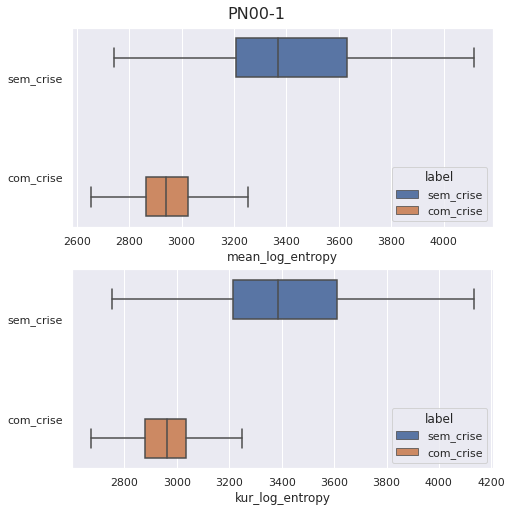

In [222]:
fig, axs = plt.subplots(2,1,figsize=(7,7), constrained_layout=True)

for col in range(len(data.columns[:-1])):
    sns.boxplot(y="label", x=data.columns[col], hue="label", data=data, ax=axs[col], showfliers=False)
    axs[col].set_ylabel('')

fig.suptitle(file.replace('.parquet',''), fontsize=16)